In [2]:
import pandas as pd 
import joblib
import numpy as np 
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

In [8]:
# Įkelkite duomenis iš CSV failo
df = pd.read_csv('mobile_autoplius.csv', sep=';')
df = df.drop(columns=['Unnamed: 0'])

# Sutvarkykite stulpelius
df['metai'] = df['metai'].astype(int)
df['kaina'] = df['kaina'].str.replace('€', '').str.replace(' ', '').astype(float)
df['rida'] = df['rida'].str.replace(' km', '').str.replace(' ', '').replace('Nenurodyta', None).astype(float)
df['kW'] = df['variklis'].str.extract(r'(\d+)kW')[0].astype(float)
df = df.drop(columns=['variklis'])
df.dropna(subset=['rida', 'kW', 'kaina', 'kuras', 'pavaros'], inplace=True)

# Sąrašas gamintojų, kuriems reikia paimti abu žodžius
double_word_manufacturers = ["Alfa Romeo", "Land Rover"]

# Funkcija gamintojo pavadinimo priskyrimui
def get_manufacturer(name):
    words = name.split()
    if len(words) > 1 and ' '.join(words[:2]) in double_word_manufacturers:
        return ' '.join(words[:2])
    else:
        return words[0]

# Paimkite teisingą gamintojo pavadinimą
df['gamintojas'] = df['gamintojas'].apply(get_manufacturer)

# Sukurkite žodyną su unikaliomis gamintojų reikšmėmis
gamintojai = {name: idx for idx, name in enumerate(df['gamintojas'].unique())}

# Funkcija gamintojo pavadinimo keitimui į skaitmeninę reikšmę
df['gamintojas'] = df['gamintojas'].map(gamintojai)
# print(df['gamintojas'].head())


# Kategorinių reikšmių pavertimas skaitinėmis reprezentacijomis stulpelyje 'kuras'
df['kuras'] = df['kuras'].map({
    'Benzinas': 0, 
    'Dyzelinas': 1, 
    'Elektra': 2, 
    'Benzinas / elektra': 3, 
    'Dyzelinas / elektra': 4, 
    'Benzinas / dujos': 5
})
df['kuras'] = df['kuras'].fillna(-1).astype(int)

# Kategorinių reikšmių pavertimas skaitinėmis reprezentacijomis stulpelyje 'pavaros'
df['pavaros'] = df['pavaros'].map({
    'Mechaninė': 0, 
    'Automatinė': 1
}).astype(int)

# Išsaugokite tvarkingus duomenis į naują CSV failą
df.to_csv('cleaned_mobile_autoplius.csv', sep=';', index=False)

print("Duomenys sėkmingai sutvarkyti ir išsaugoti į 'cleaned_mobile_autoplius.csv'")

Duomenys sėkmingai sutvarkyti ir išsaugoti į 'cleaned_mobile_autoplius.csv'


In [10]:
print('Gamintojų žodynas: ')
print(gamintojai)

Gamintojų žodynas: 
{'BMW': 0, 'Skoda': 1, 'Audi': 2, 'Volkswagen': 3, 'Peugeot': 4, 'Volvo': 5, 'Mercedes-Benz': 6, 'Subaru': 7, 'Toyota': 8, 'Land Rover': 9, 'Jaguar': 10, 'Alfa Romeo': 11, 'Opel': 12, 'Honda': 13, 'Nissan': 14, 'Suzuki': 15, 'Kia': 16, 'Chevrolet': 17, 'Hyundai': 18, 'Infiniti': 19, 'Renault': 20, 'Citroen': 21, 'Chrysler': 22, 'Mitsubishi': 23, 'Maserati': 24, 'Porsche': 25, 'Ford': 26, 'Mazda': 27, 'Lexus': 28, 'Seat': 29, 'Tesla': 30, 'Jeep': 31, 'Lancia': 32, 'Moskvich': 33, 'Fiat': 34, 'Smart': 35, 'Mini': 36, 'Daihatsu': 37, 'Pontiac': 38, 'Dacia': 39, 'Saab': 40, 'Dodge': 41, 'SsangYong': 42, 'DR': 43, 'Iveco': 44, 'Cadillac': 45, 'Aixam': 46, 'Microcar': 47, 'DS': 48, 'Ligier': 49}


In [11]:
X = df[['gamintojas', 'metai', 'rida', 'pavaros', 'kuras', 'kW']]
y = df['kaina']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']

In [17]:
models = {
    'Linear Regression':
LinearRegression(),
    'Polynomial Regression':
make_pipeline(PolynomialFeatures(degree=2), Ridge()),
    'Decision Tree':
DecisionTreeRegressor(),
    'Random Forest':
RandomForestRegressor()
}

param_grids = {
'Polynomial Regression': {
    'ridge__alpha': [0.1, 1.0, 10.0]
},
'Decision Tree': {
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
},
'Random Forest': {
    'n_estimators': [100, 200],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]}}


In [13]:
results = {}

for name, model in models.items():
    if name in param_grids:
        grid_search = GridSearchCV(model, param_grids[name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train_scaled, y_train)
        best_model = grid_search.best_estimator_
    else:
        best_model = model
        best_model.fit(X_train_scaled, y_train)
    
    y_pred = best_model.predict(X_test_scaled)
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    r2 = r2_score(y_test, y_pred)
    results[name] = {'RMSE': rmse, 'R2': r2}
    print(f'{name}: RMSE={rmse}, R2 = {r2}')

joblib.dump(best_model, 'best_model.pkl')  

C:\Users\ostap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\ostap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Linear Regression: RMSE=4900.5510126087165, R2 = 0.488519264852722
Polynomial Regression: RMSE=3587.968578590575, R2 = 0.7258194052674183


C:\Users\ostap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Decision Tree: RMSE=4455.38970958606, R2 = 0.5772234924246379
Random Forest: RMSE=3421.8448432557225, R2 = 0.750620885309963


C:\Users\ostap\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


['best_model.pkl']

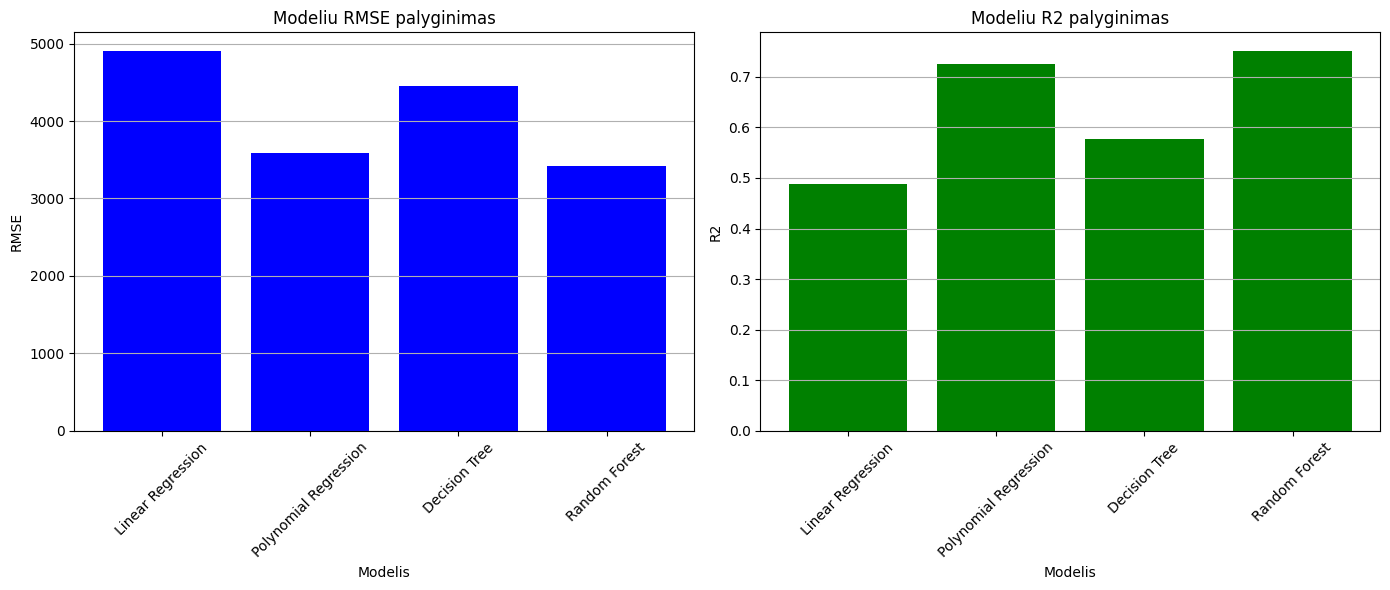

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Sukuriamas RMSE ir R^2 rezultatų sąrašai
rmse_values = [results[model]['RMSE'] for model in results]
r2_values = [results[model]['R2'] for model in results]

# RMSE
axes[0].bar(results.keys(), rmse_values, color='blue')
axes[0].set_xlabel('Modelis')
axes[0].set_ylabel('RMSE')
axes[0].set_title('Modeliu RMSE palyginimas')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, axis='y')

# R2
axes[1].bar(results.keys(), r2_values, color='green')
axes[1].set_xlabel('Modelis')
axes[1].set_ylabel('R2')
axes[1].set_title('Modeliu R2 palyginimas')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, axis='y')

# Rodyti diagramą
plt.tight_layout()
plt.show()